<a href="https://colab.research.google.com/github/youngjinjae/pythontest/blob/main/0801_%EC%A0%84%EC%9D%B4_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 전이학습을 하려고 합니다.
# 사용 할 pretrained netwrok 기 학습된 네트워크는 vgg16 이라는 연습용 network 입니다.

# CNN Model이고 convolution layer가 16개로 구성되어 있는 모델
# 일단 먼저 한번 보자..

from tensorflow.keras.applications import VGG16
# 특성 추출을 위한 기학습된 네트워크 이용
model_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

model_base.summary()
# include는 top 는 맨 뒤부분 추출해달라 false
# 멍멍이 고양이 150,150,3 학습할때 갯수 맞춰서 해야함 안그러면
# weights : imagenet 데이터로 학습된 모델을 불러옴
# include_top=false fc layer 추가할지 말지 결정 분류기를 추가할지 말지 결정
# input_shape:network에 주입될 이미지의 shape



58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# 여기에서 2가지 선택지가 있어요.
# 첫번 재로 기 학습된 network 를 이용해서 특성을 먼저 추출 해보자.
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)
batch_size=20

def extract_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count,))

    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    # generator 돌면서 20개 씩 계속 반복 작용
    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch

        i += 1
        if i * batch_size >= sample_count:
            break;

    return features, labels
# 추출 변수 확인
train_features, train_labels = extract_feature(train_dir,2000)
validation_features, validation_labels = extract_feature(validation_dir,1000)
test_features, test_labels = extract_feature(test_dir,1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step


In [ ]:
# 4차원 이미지를 2차원 이미지를 변화 시키낟.
# 이미지 하나당 2000개 싹다 곱해서 1차원으로 만들어달라.
# 150,150,3 결과에 보면 4,4,512 로 결과값 가지고
train_features = np.reshape(train_features, (2000,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000,4 * 4 * 512))
test_features = np.reshape(test_features, (1000,4 * 4 * 512))

# 데이터 준비 완료
# 이제 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

# 모델 구현
model = Sequential()

# 원래는 input layer, hidden layer,output layer 나와야함
# 하지만 input layer, 가운데 hidden layer와 함쳐서 표현할게요

model.add(Dense(256,
               activation='relu',
               input_shape=(4*4*512,))) #, tuple 차원 계산식 , 없으면 int 계산됨
model.add(Dropout(rate=0.5))
model.add(Dense(1,
               activation='sigmoid')) # 스펠링 확인 l 아니고 i
model.compile(optimizer=Adam(1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model_result = model.fit(train_features,
                        train_labels,
                        epochs=30,
                        batch_size=20,
                        validation_data=(validation_features,validation_labels))



Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4528 - accuracy: 0.7725 - val_loss: 0.2909 - val_accuracy: 0.8910
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2869 - accuracy: 0.8825 - val_loss: 0.2559 - val_accuracy: 0.8990
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2256 - accuracy: 0.9160 - val_loss: 0.2449 - val_accuracy: 0.9030
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1909 - accuracy: 0.9285 - val_loss: 0.2475 - val_accuracy: 0.8950
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1746 - accuracy: 0.9370 - val_loss: 0.2415 - val_accuracy: 0.9040
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1395 - accuracy: 0.9505 - val_loss: 0.2335 - val_accuracy: 0.9000
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1220 - accuracy: 0.9610 - val_loss: 0.2295 - val_accuracy: 0.9020
Epoch 

<function matplotlib.pyplot.show(close=None, block=None)>

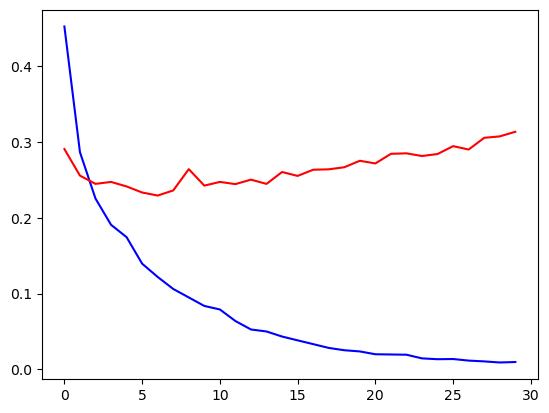

In [ ]:
# 결과 보기 그래프
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


plt.plot(model_result.history['loss'],color='b')
plt.plot(model_result.history['val_loss'],color='r')
plt.show
# 원래 파란색 선으로 가야 정상인데; 기존 거보다는 괜찮다.


In [ ]:
# 이번에는 기학습된 네트워크을 우리 모델안에 포함해서 모델을 구현할게요
# 매 epoch마다 우리 이미지 데이터 특성을 추출하기 때문에 당연히 느려져요.
# 하지만 증식을 이용하는게 가능해지는 장점도 있죠,
# 필터값과 weight,bias 를 update할때 filter 는 업데이트 되도록 하지 않는다.
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt



In [ ]:
# 학습할 데이터
train_dir= './data/cat_dog_small/train'
validation_dir='./data/cat_dog_small/validation'

# 우리는 이미지 데이터를 imagedataGenerator 를 이용해서 pixel 데이터 변경해야함
# 그리고 augmentation 같이 사용
# 이미지 데이터 증식 결과 ▼
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
# 정규화는 가능하지만 증식은 아니다. 평가를 해주는거 학습이미지 ㄱ ㅏ증식이다,

# Validation data에 대해서는 당연히 증식을 사용하면 안된다.
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats','dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats','dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# 모델
model_base=VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150,150,3))

model_base.trainable = False # 학습 filter 값들이 업데이트 안함

model = Sequential()
model.add(model_base)

# classifier 의 input layer
model.add(Flatten(input_shape=(4*4*512,))) # 4 차원을 어떻게 입력받을거냐

# hidden layer
model.add(Dense(256,
               activation='relu',
               input_shape=(4*4*512,))) #, tuple 차원 계산식 , 없으면 int 계산됨

model.add(Dropout(rate=0.5))

model.add(Dense(1,
               activation='sigmoid')) # 스펠링 확인 l 아니고 i

model.compile(optimizer=Adam(1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model_result = model.fit(train_generator,
                        steps_per_epoch=100,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50,
                        verbose=1)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 147s 1s/step - loss: 0.5367 - accuracy: 0.7190 - val_loss: 0.3288 - val_accuracy: 0.8640
Epoch 2/30
100/100 [==============================] - 153s 2s/step - loss: 0.4048 - accuracy: 0.8080 - val_loss: 0.3059 - val_accuracy: 0.8750
Epoch 3/30
100/100 [==============================] - 156s 2s/step - loss: 0.3727 - accuracy: 0.8375 - val_loss: 0.2797 - val_accuracy: 0.8830
Epoch 4/30
100/100 [==============================] - 161s 2s/step - loss: 0.3542 - accuracy: 0.8440 - val_loss: 0.2681 - val_accuracy: 0.8850
Epoch 5/30
100/100 [==============================] - 167s 2s/step - loss: 0.3382 - accuracy: 0.8415 - val_loss: 0.2651 - val_accuracy: 0.8880
Epoch 6/30
100/100 [==============================] - 163s 2s/step - loss: 0.3272 - accuracy: 0.8635 - val_loss: 0.2550 - val_accuracy: 0.9030
Epoch 7/30
100/100 [==============================] - 160s

In [ ]:
# 학습할 데이터
train_dir= './data/cat_dog_small/train'
validation_dir='./data/cat_dog_small/validation'

# 우리는 이미지 데이터를 imagedataGenerator 를 이용해서 pixel 데이터 변경해야함
# 그리고 augmentation 같이 사용
# 이미지 데이터 증식 결과 ▼
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
# 정규화는 가능하지만 증식은 아니다. 평가를 해주는거 학습이미지 ㄱ ㅏ증식이다,

# Validation data에 대해서는 당연히 증식을 사용하면 안된다.
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats','dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats','dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# 모델
model_base=VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150,150,3))

model_base.trainable = False # 학습 filter 값들이 업데이트 안함

model = Sequential()
model.add(model_base)

# classifier 의 input layer
model.add(Flatten(input_shape=(4*4*512,))) # 4 차원을 어떻게 입력받을거냐

# hidden layer
model.add(Dense(256,
               activation='relu',
               input_shape=(4*4*512,))) #, tuple 차원 계산식 , 없으면 int 계산됨

model.add(Dropout(rate=0.5))

model.add(Dense(1,
               activation='sigmoid')) # 스펠링 확인 l 아니고 i

model.compile(optimizer=Adam(1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model_base.trainable = True

for layer in model_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

# model.summary()
# model.VGG16.summary()

#model_result = model.fit(train_generator,
#                         steps_per_epoch=100,
#                         epochs=30,
#                         validation_data=validation_generator,
#                         validation_steps=50,
#                         verbose=1)

# fine tuning 까지 진행하면
# 4000개의 이미지를 가지고 93% 정도까지 accuracy 올릴 수있다.

# 전체 데이터(25000)를 가지고 fine tuning해서 학습 하면 96% 까지
# 올릴수 있다.

# efficientnet 을 이용해서 처리해 보아라
# vgg16 대신 성능이 좋은 다른 pretrained network를 이용하면
# 얼마나 accuracy 올라가는지 확인해보면 된다.
# 95%이상 나오면 될거 같아요.





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

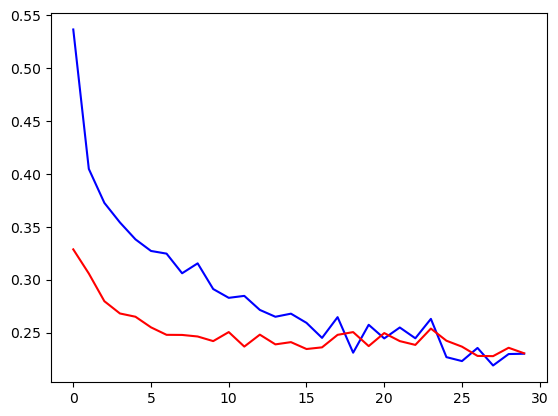

In [ ]:

plt.plot(model_result.history['loss'],color='b')
plt.plot(model_result.history['val_loss'],color='r')
plt.show